# ARIM-Academy：　機器データ利活用ユースケース（2）
### 機器：走査電子顕微鏡（SEM）
### 分析：CNNによる画像識別　（学習編）

## データセット

**『LIBカソード電極のSEMデータセット』**は、さまざまなLi（Ni、Co、Mn）O 2（NCM）カソードの主な組成（例：333、523、622、および811）とさまざまな状態（例：初期、サイクル前、および100回サイクル）を分類する予測モデルを開発を目的に集められた走査電子顕微鏡（SEM）画像です。

[1] Oh, J., Yeom, J., Madika, B. et al. Composition and state prediction of lithium-ion cathode via convolutional neural network trained on scanning electron microscopy images. npj Comput Mater 10, 88 (2024). https://doi.org/10.1038/s41524-024-01279-6

<img src="./img/image.png" alt="メインイメージ">

### コードへの接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!git clone https://github.com/ARIM-Usecase/Example_4.git
%cd Example_4

### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
#I/Oライブラリ
from tqdm import tqdm
import os

#汎用ライブラリ
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#機械学習/深層学習ライブラリ
import torch
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

# utilモジュール
from module.config import get_config
from module.utils import load_datasets
from module.utils import loss_fn
from module.utils import optimize_fn

In [2]:

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

### 初期設定

In [3]:
dataset_name = 'example'
version = 'v1'
config = get_config(dataset_name, version)
save_name = dataset_name + '_' + version

In [4]:
seed = config['seed']
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [6]:
root_dir = config['data_dir']
print("The data lies here =>", root_dir)

The data lies here => ./data/example


## CNNモデルの構築

### データセットの分割（Data set splitting）
データセットの分割（Data set splitting）は、機械学習モデルの訓練と評価のために、データセットを訓練データとテストデータに分けるプロセスを指します。モデルがテストデータに対してどれくらい正確に予測できるかを評価することで、モデルの汎化能力や性能を測定します。

In [7]:
train_set, validate_set = load_datasets(config)

train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=config['batch_size'])
val_loader = DataLoader(dataset=validate_set, shuffle=False, batch_size=config['batch_size'])

### モデル構築

In [8]:
if config['pretrained']:
    model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=12)  # Pre-trained
else:
    model = EfficientNet.from_name('efficientnet-b7', num_classes=12)  # from model

Loaded pretrained weights for efficientnet-b7


In [9]:
model.to(device)

criterion = loss_fn(config)
optimizer = optimize_fn(config, model.parameters())

In [10]:
accuracy_stats = {
    "train": [],
    "val": []
}
loss_stats = {
    "train": [],
    "val": []
}

print("Begin training.")
acc_train = 0

Begin training.


### 訓練と検証の最適化
GPUで約20分の計算時間です。CPUの場合には約10時間近くとなります。epochの回数を50回から10回へ変更するなどでトライアルしてみてください。

（config.pyのdef gen_default()の引数にあるepoch=50をepoch=10とする）

In [11]:
%time

for e in range(1, config['epoch'] + 1):
    num_cnt = 0
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()

    for X_train_batch, y_train_batch, _ in tqdm(train_loader):

        inputs, labels = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

        num_cnt = len(labels)

        train_epoch_loss += float(train_loss.item() * inputs.size(0) / num_cnt)
        train_corr = torch.sum(preds == labels.data)

        train_epoch_acc += float((train_corr.double() / num_cnt).cpu() * 100)
    
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch, _ in tqdm(val_loader):
            inputs, labels = X_val_batch.to(device), y_val_batch.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  
            val_loss = criterion(outputs, labels)

            num_cnt = len(labels)

            val_epoch_loss += float(val_loss.item() * inputs.size(0) / num_cnt)
            val_corr = torch.sum(preds == labels.data)

            val_epoch_acc += float((val_corr.double() / num_cnt).cpu() * 100)
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    
    print(f'\n Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    
    # save the model
    if acc_train < train_epoch_acc/len(train_loader):
        print('Accuracy improved from {} to {}. Model saved.'.format(
            acc_train, train_epoch_acc/len(train_loader)))
        acc_train = train_epoch_acc/len(train_loader)
        torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
        }, f'./{root_dir}/{save_name}.pth')

Wall time: 0 ns


100%|██████████| 20/20 [00:01<00:00, 12.83it/s]



 Epoch 01: | Train Loss: 1.09779 | Val Loss: 1.40264 | Train Acc: 68.125| Val Acc: 36.250
Accuracy improved from 0 to 68.125. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.90it/s]



 Epoch 02: | Train Loss: 0.65765 | Val Loss: 1.57091 | Train Acc: 80.000| Val Acc: 50.000
Accuracy improved from 68.125 to 80.0. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.62it/s]



 Epoch 03: | Train Loss: 0.52278 | Val Loss: 2.64195 | Train Acc: 81.875| Val Acc: 26.250
Accuracy improved from 80.0 to 81.875. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.71it/s]



 Epoch 04: | Train Loss: 0.29837 | Val Loss: 3.79314 | Train Acc: 91.250| Val Acc: 37.500
Accuracy improved from 81.875 to 91.25. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.94it/s]



 Epoch 05: | Train Loss: 0.30499 | Val Loss: 0.97512 | Train Acc: 88.750| Val Acc: 51.250


100%|██████████| 20/20 [00:01<00:00, 12.90it/s]



 Epoch 06: | Train Loss: 0.18615 | Val Loss: 0.51903 | Train Acc: 94.375| Val Acc: 78.750
Accuracy improved from 91.25 to 94.375. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.79it/s]



 Epoch 07: | Train Loss: 0.18137 | Val Loss: 2.45501 | Train Acc: 94.688| Val Acc: 60.000
Accuracy improved from 94.375 to 94.6875. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.55it/s]



 Epoch 08: | Train Loss: 0.18258 | Val Loss: 0.13158 | Train Acc: 94.062| Val Acc: 96.250


100%|██████████| 20/20 [00:01<00:00, 12.92it/s]



 Epoch 09: | Train Loss: 0.27260 | Val Loss: 0.50280 | Train Acc: 92.188| Val Acc: 80.000


100%|██████████| 20/20 [00:01<00:00, 12.68it/s]



 Epoch 10: | Train Loss: 0.15998 | Val Loss: 0.02744 | Train Acc: 94.062| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.46it/s]



 Epoch 11: | Train Loss: 0.06404 | Val Loss: 0.06980 | Train Acc: 98.438| Val Acc: 97.500
Accuracy improved from 94.6875 to 98.4375. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.71it/s]



 Epoch 12: | Train Loss: 0.06539 | Val Loss: 0.01675 | Train Acc: 98.750| Val Acc: 100.000
Accuracy improved from 98.4375 to 98.75. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.57it/s]



 Epoch 13: | Train Loss: 0.26818 | Val Loss: 0.03199 | Train Acc: 93.438| Val Acc: 98.750


100%|██████████| 20/20 [00:01<00:00, 12.56it/s]



 Epoch 14: | Train Loss: 0.16247 | Val Loss: 0.15864 | Train Acc: 95.312| Val Acc: 95.000


100%|██████████| 20/20 [00:01<00:00, 12.36it/s]



 Epoch 15: | Train Loss: 0.11611 | Val Loss: 0.03812 | Train Acc: 97.500| Val Acc: 98.750


100%|██████████| 20/20 [00:01<00:00, 11.66it/s]



 Epoch 16: | Train Loss: 0.06940 | Val Loss: 0.01294 | Train Acc: 98.750| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.45it/s]



 Epoch 17: | Train Loss: 0.17028 | Val Loss: 0.20274 | Train Acc: 95.000| Val Acc: 92.500


100%|██████████| 20/20 [00:01<00:00, 12.86it/s]



 Epoch 18: | Train Loss: 0.16787 | Val Loss: 0.23157 | Train Acc: 96.250| Val Acc: 92.500


100%|██████████| 20/20 [00:01<00:00, 12.71it/s]



 Epoch 19: | Train Loss: 0.16169 | Val Loss: 0.03239 | Train Acc: 95.000| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.95it/s]



 Epoch 20: | Train Loss: 0.05893 | Val Loss: 0.01648 | Train Acc: 98.438| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.86it/s]



 Epoch 21: | Train Loss: 0.14619 | Val Loss: 0.03820 | Train Acc: 97.500| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 13.05it/s]



 Epoch 22: | Train Loss: 0.04713 | Val Loss: 0.03138 | Train Acc: 98.125| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.83it/s]



 Epoch 23: | Train Loss: 0.13983 | Val Loss: 0.00744 | Train Acc: 95.938| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.79it/s]



 Epoch 24: | Train Loss: 0.10649 | Val Loss: 0.01588 | Train Acc: 97.500| Val Acc: 98.750


100%|██████████| 20/20 [00:01<00:00, 12.95it/s]



 Epoch 25: | Train Loss: 0.14627 | Val Loss: 0.04438 | Train Acc: 96.875| Val Acc: 97.500


100%|██████████| 20/20 [00:01<00:00, 12.94it/s]



 Epoch 26: | Train Loss: 0.07954 | Val Loss: 0.00673 | Train Acc: 98.438| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.95it/s]



 Epoch 27: | Train Loss: 0.03078 | Val Loss: 0.01813 | Train Acc: 99.062| Val Acc: 100.000
Accuracy improved from 98.75 to 99.0625. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.33it/s]



 Epoch 28: | Train Loss: 0.01898 | Val Loss: 0.00596 | Train Acc: 99.375| Val Acc: 100.000
Accuracy improved from 99.0625 to 99.375. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.72it/s]



 Epoch 29: | Train Loss: 0.05311 | Val Loss: 0.04954 | Train Acc: 98.438| Val Acc: 98.750


100%|██████████| 20/20 [00:01<00:00, 12.84it/s]



 Epoch 30: | Train Loss: 0.12234 | Val Loss: 0.07458 | Train Acc: 97.188| Val Acc: 98.750


100%|██████████| 20/20 [00:01<00:00, 12.92it/s]



 Epoch 31: | Train Loss: 0.11237 | Val Loss: 0.00642 | Train Acc: 96.250| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.38it/s]



 Epoch 32: | Train Loss: 0.06019 | Val Loss: 0.56807 | Train Acc: 98.125| Val Acc: 85.000


100%|██████████| 20/20 [00:01<00:00, 12.88it/s]



 Epoch 33: | Train Loss: 0.17288 | Val Loss: 0.04300 | Train Acc: 97.812| Val Acc: 98.750


100%|██████████| 20/20 [00:01<00:00, 12.72it/s]



 Epoch 34: | Train Loss: 0.03271 | Val Loss: 0.00209 | Train Acc: 99.062| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.74it/s]



 Epoch 35: | Train Loss: 0.18000 | Val Loss: 0.09309 | Train Acc: 94.375| Val Acc: 97.500


100%|██████████| 20/20 [00:01<00:00, 12.32it/s]



 Epoch 36: | Train Loss: 0.11582 | Val Loss: 0.20210 | Train Acc: 96.875| Val Acc: 90.000


100%|██████████| 20/20 [00:01<00:00, 12.73it/s]



 Epoch 37: | Train Loss: 0.17891 | Val Loss: 0.69745 | Train Acc: 93.438| Val Acc: 80.000


100%|██████████| 20/20 [00:01<00:00, 12.61it/s]



 Epoch 38: | Train Loss: 0.19100 | Val Loss: 0.00445 | Train Acc: 92.812| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.77it/s]



 Epoch 39: | Train Loss: 0.08930 | Val Loss: 0.00752 | Train Acc: 96.250| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.83it/s]



 Epoch 40: | Train Loss: 0.06191 | Val Loss: 0.00323 | Train Acc: 98.750| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.60it/s]



 Epoch 41: | Train Loss: 0.03220 | Val Loss: 0.02580 | Train Acc: 99.375| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.74it/s]



 Epoch 42: | Train Loss: 0.05082 | Val Loss: 0.01206 | Train Acc: 98.750| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 11.90it/s]



 Epoch 43: | Train Loss: 0.00612 | Val Loss: 0.00762 | Train Acc: 100.000| Val Acc: 100.000
Accuracy improved from 99.375 to 100.0. Model saved.


100%|██████████| 20/20 [00:01<00:00, 12.66it/s]



 Epoch 44: | Train Loss: 0.08986 | Val Loss: 0.03778 | Train Acc: 98.438| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.80it/s]



 Epoch 45: | Train Loss: 0.09194 | Val Loss: 0.02238 | Train Acc: 97.188| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.43it/s]



 Epoch 46: | Train Loss: 0.01244 | Val Loss: 0.00414 | Train Acc: 99.688| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.59it/s]



 Epoch 47: | Train Loss: 0.01207 | Val Loss: 0.00727 | Train Acc: 99.688| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 12.42it/s]



 Epoch 48: | Train Loss: 0.00953 | Val Loss: 0.00378 | Train Acc: 99.688| Val Acc: 100.000


100%|██████████| 20/20 [00:01<00:00, 10.54it/s]



 Epoch 49: | Train Loss: 0.01838 | Val Loss: 0.06878 | Train Acc: 99.375| Val Acc: 98.750


100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


 Epoch 50: | Train Loss: 0.01902 | Val Loss: 0.10418 | Train Acc: 99.375| Val Acc: 95.000


### モデルの評価：精度の計算

In [12]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(
    id_vars=['index']).rename(columns={"index": "epochs"})

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(
    id_vars=['index']).rename(columns={"index": "epochs"})

### 可視化

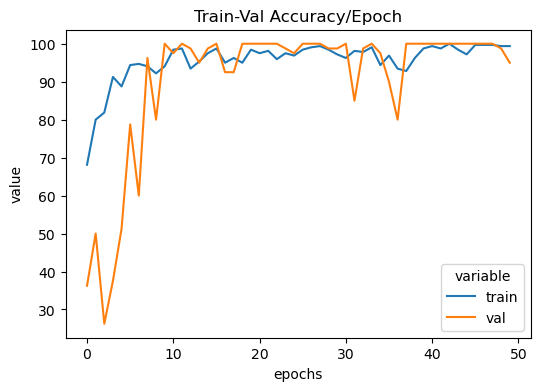

In [22]:
#精度の可視化

fig, axes = plt.subplots(figsize=(6, 4))

sns.lineplot(data=train_val_acc_df, 
            x="epochs", 
            y="value",
            hue="variable"
            ).set_title('Train-Val Accuracy/Epoch')

plt.savefig(f'./{root_dir}/Accuracy.png', dpi=300)

plt.show()

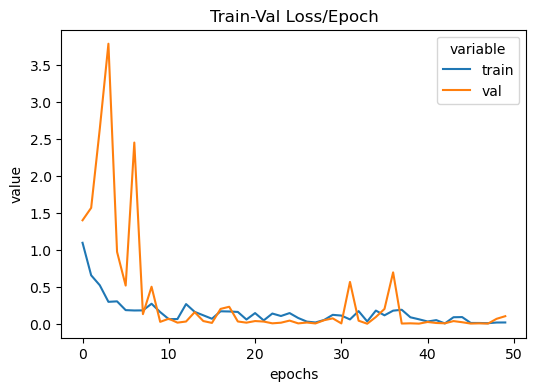

In [23]:
#損失関数の値の可視化

fig, axes = plt.subplots(figsize=(6, 4))

sns.lineplot(data=train_val_loss_df, 
            x="epochs", 
            y="value",
            hue="variable"
            ).set_title('Train-Val Loss/Epoch')

plt.savefig(f'./{root_dir}/Loss.png', dpi=300)

plt.show()